# Tutorial Design: Self-Driving Cab


Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

- Drop off the passenger to the right location.
- Save passenger's time by taking minimum time possible to drop off
- Take care of passenger's safety and traffic rules

> There are different aspects that need to be considered here while modeling an RL solution to this problem: **rewards**, **states**, and **actions**.

# Rewards
Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. 
### Here a few points to consider:

- The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
- The agent should be penalized if it tries to drop off a passenger in wrong locations
- The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible



# State Space
In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

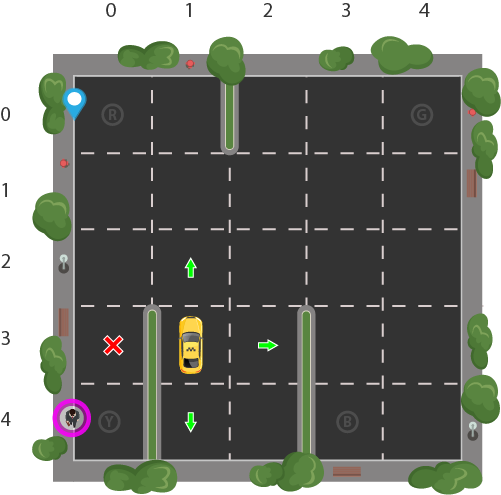

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has 
 

5 X 5 X 5 X 4 = 500 total possible states.

# Action Space
The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have six possible actions:

- South
- North
- East
- West
- Pickup
- Dropoff

This is the action space: the set of all the actions that our agent can take in a given state.

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

# Implementation with RL


 First, we import all necessary libraries and simulate the environment
 change render_mode = human if you wish to see the TAX 

In [11]:
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
#env = gym.make('Taxi-v3', render_mode='rgb_array')
# "Set render_mode to 'human' if you want to visualize the taxi environment."
# env = gym.make('Taxi-v3', render_mode='human')
env = gym.make('Taxi-v3', render_mode='rgb_array')


 The environment is shown below, where the letters (R, G, Y, B) represents the different
locations and a tiny yellow colored rectangle is the taxi driving by our agent.

In [12]:
env.reset()
env.render()

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

The core gym interface is env, which is the unified environment interface. The following are the env methods that would be quite helpful to us:

- env.reset: Resets the environment and returns a random initial state.
- env.step(action): Step the environment by one timestep. Returns
- observation: Observations of the environment
- reward: If your action was beneficial or not
- done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
- info: Additional info such as performance and latency for debugging purposes
- env.render: Renders one frame of the environment (helpful in visualizing the environment)
- Note: We are using the .env on the end of make to avoid training stopping at 200 iterations, which is the default for the new version of Gym (reference).


### Reminder of our problem


Here's our restructured problem statement (from Gym docs):

> "There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Let's dive more into the environment.



In [13]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))



Action Space Discrete(6)
State Space Discrete(500)


As verified by the prints, we have an Action Space of size 6 and a State Space of size 500. As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

- 0 = south
- 1 = north
- 2 = east
- 3 = west
- 4 = pickup
- 5 = dropoff
Recall that the 500 states correspond to a encoding of the taxi's location, the passenger's location, and the destination location.

Reinforcement Learning will learn a mapping of states to the optimal action to perform in that state by exploration, i.e. the agent explores the environment and takes actions based off rewards defined in the environment.

The optimal action for each state is the action that has the highest cumulative long-term reward.



In [14]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328


array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

# The Reward Table
When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a states x actions matrix.
env.P to print for all states or env.P[stateNum]
Since every state is in this matrix, we can see the default reward values assigned to our illustration's state: 328

In [15]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.



A few things to note:

- The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
- In this env, probability is always 1.0.
- The nextstate is the state we would be in if we take the action at this index of the dict
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
- done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an **episode**

Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.



### Episode End
The episode ends if the following happens:

- Termination: 1. The taxi drops off the passenger.

- Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.



###  Solving the environment without Reinforcement Learning


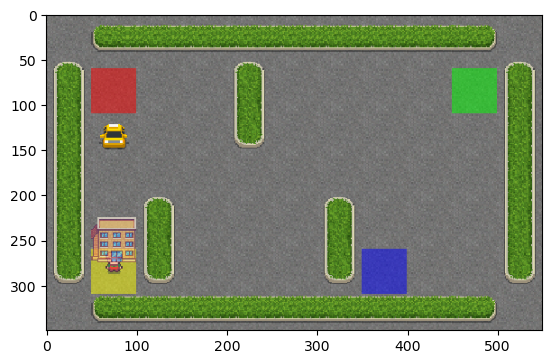

In [19]:
# Try  random actions 
for i in range(2500):
   plt.imshow(env.render())
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(env.action_space.sample())

  

In [17]:

# Let us set the environmet to illustration's state 
env.s = 328
epochs = 0 
penalties = 0
reward= 0
frames = []
terminated = False
while not terminated:
 action = env.action_space.sample()
 state, reward, terminated, truncated, info = env.step(action)
 if reward == -10:
  penalties = penalties + 1
 
 print(f"Timestep: {epochs + 1}")
 print(f"State: {state}")
 print(f"Action: {action}")
 print(f"Reward: {reward}")
 epochs += 1



print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timestep: 1
State: 414
Action: 2
Reward: -1
Timestep: 2
State: 414
Action: 3
Reward: -1
Timestep: 3
State: 414
Action: 3
Reward: -1
Timestep: 4
State: 414
Action: 5
Reward: -10
Timestep: 5
State: 414
Action: 4
Reward: -10
Timestep: 6
State: 414
Action: 2
Reward: -1
Timestep: 7
State: 314
Action: 1
Reward: -1
Timestep: 8
State: 214
Action: 1
Reward: -1
Timestep: 9
State: 214
Action: 3
Reward: -1
Timestep: 10
State: 214
Action: 3
Reward: -1
Timestep: 11
State: 214
Action: 4
Reward: -10
Timestep: 12
State: 214
Action: 5
Reward: -10
Timestep: 13
State: 314
Action: 0
Reward: -1
Timestep: 14
State: 414
Action: 0
Reward: -1
Timestep: 15
State: 414
Action: 3
Reward: -1
Timestep: 16
State: 414
Action: 0
Reward: -1
Timestep: 17
State: 314
Action: 1
Reward: -1
Timestep: 18
State: 314
Action: 4
Reward: -10
Timestep: 19
State: 314
Action: 2
Reward: -1
Timestep: 20
State: 314
Action: 2
Reward: -1
Timestep: 21
State: 214
Action: 1
Reward: -1
Timestep: 22
State: 314
Action: 0
Reward: -1
Timestep: 23
S